# Exploring GLODAP data

We are interested in the global ocean as a reservoir of heat, oxygen and salt. These are baseline characteristics
that help us understand how the ocean works. 


## Technical notes

In some cases it may be necessary to enable the Jupyter notebook extension for widgets. 
From the command line issue `jupyter nbextension enable --py widgetsnbextension`.


The data files reside either in a dedicated data filesystem `/data` or in a data subfolder of the user's home directory. 
Respectively these are for the dedicated VM and the JupyterHub pod user scenarios respectively. There are some 
corresponding either/or elements of the procedures.  


Is the `cmocean` install necessary? Is the `boto` install necessary? It depends again: For JupyterHub pods: Likely necessary. 
For a pre-configured machine image (the dedicated Virtual Machine scenario): Likely unnecessary since these can be installed
when preparing the VM for the image snapshot. 


On interactive widgets: `https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916`

On [GLODAP](https://en.wikipedia.org/wiki/Global_Ocean_Data_Analysis_Project): The data are a snapshot description
of the state of the ocean. It is based upon observational data spanning several decades. Here we are interested in 
salinity, temperature and dissolved oxygen as functions of depth and location.


The data are coarse resolution in the map plane and are located non-linearly in depth. Each slider setting prints
the corresponding current depth of the data view on the plot. 

In [5]:
# mini-source control: Last copied 29-SEP-2020: to tilt*, chlorophyll*, rca*, argo*
#                      last revised 09-OCT-2020
import os, sys, time, glob

from IPython.display import clear_output             # use inside loop with clear_output(wait = True) followed by print(i)
import warnings                                      # use with warnings.filterwarnings('ignore') or 'once'
warnings.filterwarnings('ignore')

home_dir = os.getenv("HOME")
this_dir = home_dir + '/chlorophyll/'
data_dir = '/data/'
data1_dir = '/data1'

from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64

def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D')) # 1, 2, .... , 365, [366]
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


In [2]:
######################
#
# preparation to use the 'cmocean' colortables
#
######################

# !conda install -c conda-forge cmocean -y -q

In [13]:
######################
#
# preparation for the glodap explorer (next cell)
#
######################

from ipywidgets import *
from traitlets import dlink

# 'import os' is not necessary: It happens in the code above...

pangeo_jupyter = False
home_dir = os.getenv("HOME")
this_dir = home_dir + '/chlorophyll/'
if pangeo_jupyter: data_dir = home_dir + '/data/'
else: data_dir = '/datadrive/azureuser/'


# if the following import fails: Run the cell above
import cmocean

from matplotlib import pyplot as plt

# not needed:
# from matplotlib import colors as mplcolors   # map data values to colors
# from matplotlib import animation, rc
# %matplotlib inline
# import numpy as np

import xarray as xr

In [14]:
%matplotlib inline

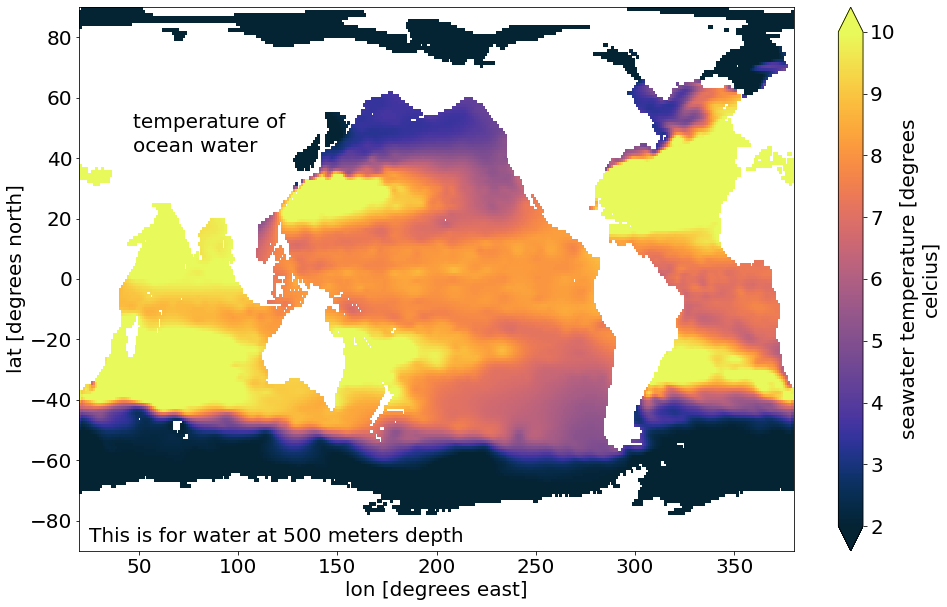

<function __main__.glodap_pTemp(depth_index)>

In [15]:
##########################
#
# glodap widget explorer: See what happens to each parameter with depth
#
##########################

# Usage notes
#   If this cell produces 'OSError: no files to open' you may need to run the data loader in the cell below. The
#   objective is to have the three NetCDF files resident in /data/glodap or in ~/data/glodap. See the comment
#   at the top of this file on two different Jupyterlab server cases. Also ensure data_dir is built correctly.
#
#   The slider for each image changes the depth of the data view. When a region becomes white: This is because the ocean does 
#     not go that deep in that location. This feature can be used to highlight the mid-oceanic ridges for example. 

glodapTemperatureFnm = data_dir + '/glodap/glodap_temperature.nc'
glodapSalinityFnm    = data_dir + '/glodap/glodap_salinity.nc'
glodapOxygenFnm      = data_dir + '/glodap/glodap_oxygen.nc'

glodap_dsSal  = xr.open_mfdataset(glodapSalinityFnm, combine='by_coords')
glodap_dsTemp = xr.open_mfdataset(glodapTemperatureFnm, combine='by_coords')
glodap_dsO2   = xr.open_mfdataset(glodapOxygenFnm, combine='by_coords')

plt.rcParams.update({'font.size': 20})

def glodap_pO2(depth_index):
    glodap_dsO2['oxygen'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=cmocean.cm.oxy,vmin=150, vmax=350)
    if depth_index == 0: msg = 'This is for surface water'
    else:                msg = 'This is for water at ' + str(int(glodap_dsO2['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(28, 50, 'oxygen dissolved in'); plt.text(28, 42, '     ocean water   ')

def glodap_pSal(depth_index):
    glodap_dsSal['salinity'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=cmocean.cm.haline,vmin=33, vmax=36)
    if depth_index == 0:msg = 'This is for surface water'
    else: msg = 'This is for water at ' + str(int(glodap_dsSal['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(47, 50, 'salinity of'); plt.text(47, 42, 'ocean water')

def glodap_pTemp(depth_index):
    glodap_dsTemp['temperature'].sel(depth_surface = depth_index).plot(figsize=(16, 10),cmap=cmocean.cm.thermal,vmin=2., vmax=10.)
    if depth_index == 0: msg = 'This is for surface water'
    else: msg = 'This is for water at ' + str(int(glodap_dsTemp['Depth'].values[depth_index])) + ' meters depth'
    plt.text(25, -87, msg); plt.text(47, 50, 'temperature of'); plt.text(47, 42, 'ocean water')

interact(glodap_pO2,   depth_index=widgets.IntSlider(min=0, max=32, step=1, value=5,  continuous_update=False, description='depth'))
interact(glodap_pSal,  depth_index=widgets.IntSlider(min=0, max=32, step=1, value=0,  continuous_update=False, description='depth'))
interact(glodap_pTemp, depth_index=widgets.IntSlider(min=0, max=32, step=1, value=13, continuous_update=False, description='depth'))


In [104]:
import panel as pn
pn.extension()

In [105]:
import hvplot.xarray

In [106]:
# Co-opting Dhruv's dashboard code... start by defining two widgets where "PO" is short for "Physical Ocean"
PO_var_select = pn.widgets.Select(name='parameter', options = ['oxygen','salinity','temperature'])
depth_slider = pn.widgets.IntSlider(start=0, end = 32)    # for double-param: time_range_slider()

In [107]:
# map??? why not?
@pn.depends(PO_var_select, depth_slider)    # these are widgets 
def my_map(PO_sel, depth_sel):              # these are parameters
    PO_plot     = plot_PO(depth_sel, PO_sel)    # this is an as-yet-undefined function
    return_plot = PO_plot.opts(frame_width=800, frame_height=400, xlim=(20,380), ylim=(-85,85)).opts(title='rth')
    return return_plot

### on using `hvplot.image()`

The goal here is to fix the data dynamic range (colorbar range) a priori rather than based on a selected depth
slice. This narrates process.


First let's make it easier to work with a block of data (a DataArray):


`fu = glodap_dsO2['oxygen'].where(glodap_dsO2.depth_surface==0, drop=True)`


Above: The `import hvplot.xarray` installs the `hvplot` extension so we can do `fu.hvplot.image()`. What arguments will this take? Some Python machinery:


`print(fu.hvplot.image.__code__.co_varnames)` --> `('self', 'x', 'y', 'z', 'colorbar', 'kwds')`


This begs the question: What are possible keywords implied by `kwds`? `inspect` can turn this over:


```
import inspect
inspect.signature(fu.hvplot.image)
```


produces


```
<Signature (x=None, y=None, z=None, colorbar=True, *, alpha, cmap, muted, visible, logz, width, height, shared_axes, grid, legend, rot, xlim, ylim, xticks, yticks, invert, title, logx, logy, loglog, xaxis, yaxis, xformatter, yformatter, xlabel, ylabel, clabel, padding, responsive, max_height, max_width, min_height, min_width, frame_height, frame_width, aspect, data_aspect, fontscale, datashade, rasterize, x_sampling, y_sampling, aggregator, **kwargs)>
```

Still no sign of dynamic range. What else can `requests` do? I used `dir(requests)` to get a big list; 
and started working through them. Most fail mysteriously but `print(inspect.getdoc(fu.hvplot.image))` 
worked great. The output matches the
[hvplot Customization doc here](https://hvplot.holoviz.org/user_guide/Customization.html).
Also works: `print(inspect.getfullargspec(fu.hvplot.image))` and 
`inspect.signature(hvplot.converter.HoloViewsConverter)` but no solution to the problem. 

In [250]:
# interesting but not working... 
#   geo=False
#   coastline=False
#   

data_O2   = [glodap_dsO2['oxygen'].where(glodap_dsO2.depth_surface == i, drop = True) for i in range(33)]
data_Sal  = [glodap_dsSal['salinity'].where(glodap_dsSal.depth_surface == i, drop = True) for i in range(33)]
data_Temp = [glodap_dsTemp['temperature'].where(glodap_dsTemp.depth_surface == i, drop = True) for i in range(33)]

In [243]:
glodap_dsO2.Depth.values[4]

50.0

In [251]:
def plot_PO(depth_sel, PO_sel):
    ts1, ts2, tsO, tsS, tsT = 'ocean surface', ' meters depth', 'Oxygen at ', 'Salinity at ', 'Temperature at '
    if PO_sel == 'oxygen':
        ts = tsO + ts1 if depth_sel == 0 else tsO + str(int(glodap_dsO2.Depth.values[depth_sel])) + ts2
        plot_gen = data_O2[depth_sel].hvplot.image(title=ts, y='lat', cmap=cmocean.cm.oxy, clabel='O2', clim=(150,350),                
                                                 grid=True, hover=False, ylabel='lat', xlabel='lon')
    elif PO_sel == 'salinity':
        ts = tsS + ts1 if depth_sel == 0 else tsS + str(int(glodap_dsO2.Depth.values[depth_sel])) + ts2
        plot_gen = data_Sal[depth_sel].hvplot.image(title=ts, y='lat', cmap=cmocean.cm.haline, clabel='Sal', clim=(33, 36),                
                                                  grid=True, hover=False, ylabel='lat', xlabel='lon')
    elif PO_sel == 'temperature':
        ts = tsT + ts1 if depth_sel == 0 else tsT + str(int(glodap_dsO2.Depth.values[depth_sel])) + ts2
        plot_gen  = data_Temp[depth_sel].hvplot.image(title=ts, y='lat', cmap=cmocean.cm.thermal, clabel='Temp', clim=(2., 10.),                
                                                  grid=True, hover=False, ylabel='lat', xlabel='lon')
    return plot_gen

@pn.depends(PO_var_select, depth_slider)    # these are widgets 
def my_map(PO_sel, depth_sel):              # these are parameters
    PO_plot     = plot_PO(depth_sel, PO_sel)    # this is an as-yet-undefined function
    return_plot = PO_plot.opts(frame_width=800, frame_height=600, xlim=(20,380), ylim=(-85,85)) # .opts(title='rth')
    return return_plot

Surf = pn.Column(
            pn.panel('#### global ocean physical data benchmarks'),
            pn.WidgetBox(PO_var_select, depth_slider),
            my_map
        )

Surf

Column
    [0] Markdown(str)
    [1] WidgetBox
        [0] Select(name='parameter', options=['oxygen', 'salinity', ...], value='oxygen')
        [1] IntSlider(end=32, value=20, value_throttled=20)
    [2] ParamFunction(function)

In [172]:
fu = glodap_dsO2['oxygen'].where(glodap_dsO2.depth_surface==0, drop=True)
print(fu.hvplot.image.__code__.co_varnames)

('self', 'x', 'y', 'z', 'colorbar', 'kwds')


In [140]:
import inspect
inspect.signature(fu.hvplot.image)

<Signature (x=None, y=None, z=None, colorbar=True, *, alpha, cmap, muted, visible, logz, width, height, shared_axes, grid, legend, rot, xlim, ylim, xticks, yticks, invert, title, logx, logy, loglog, xaxis, yaxis, xformatter, yformatter, xlabel, ylabel, clabel, padding, responsive, max_height, max_width, min_height, min_width, frame_height, frame_width, aspect, data_aspect, fontscale, datashade, rasterize, x_sampling, y_sampling, aggregator, **kwargs)>

In [198]:
print(inspect.getdoc(fu.hvplot.image))

Image plot

Parameters
----------
x, y : string, optional
    The coordinate variable along the x- and y-axis
z : string, optional
    The data variable to plot
colorbar: boolean
    Whether to display a colorbar
**kwds : optional
    Keyword arguments to pass on to
    :py:meth:`hvplot.converter.HoloViewsConverter`.
Returns
-------
obj : HoloViews object
    The HoloViews representation of the plot.


Generic options
---------------
colorbar (default=False): boolean
    Enables colorbar
fontscale: number
    Scales the size of all fonts by the same amount, e.g. fontscale=1.5
    enlarges all fonts (title, xticks, labels etc.) by 50%
fontsize: number or dict
    Set title, label and legend text to the same fontsize. Finer control
    by using a dict: {'title': '15pt', 'ylabel': '5px', 'ticks': 20}
flip_xaxis/flip_yaxis: boolean
    Whether to flip the axis left to right or up and down respectively
grid (default=False): boolean
    Whether to show a grid
hover : boolean
    Whether to s

In [219]:
print(inspect.getfullargspec(fu.hvplot.image))

FullArgSpec(args=['self', 'x', 'y', 'z', 'colorbar'], varargs=None, varkw='kwargs', defaults=(None, None, None, True), kwonlyargs=['alpha', 'cmap', 'muted', 'visible', 'logz', 'width', 'height', 'shared_axes', 'grid', 'legend', 'rot', 'xlim', 'ylim', 'xticks', 'yticks', 'invert', 'title', 'logx', 'logy', 'loglog', 'xaxis', 'yaxis', 'xformatter', 'yformatter', 'xlabel', 'ylabel', 'clabel', 'padding', 'responsive', 'max_height', 'max_width', 'min_height', 'min_width', 'frame_height', 'frame_width', 'aspect', 'data_aspect', 'fontscale', 'datashade', 'rasterize', 'x_sampling', 'y_sampling', 'aggregator'], kwonlydefaults=None, annotations={})


In [217]:
inspect.signature(hvplot.converter.HoloViewsConverter)

<Signature (data, x, y, kind=None, by=None, use_index=True, group_label='Variable', value_label='value', backlog=1000, persist=False, use_dask=False, crs=None, fields={}, groupby=None, dynamic=True, grid=None, legend=None, rot=None, title=None, xlim=None, ylim=None, clim=None, symmetric=None, logx=None, logy=None, loglog=None, hover=None, subplots=False, label=None, invert=False, stacked=False, colorbar=None, datashade=False, rasterize=False, row=None, col=None, figsize=None, debug=False, framewise=True, aggregator=None, projection=None, global_extent=None, geo=False, precompute=False, flip_xaxis=None, flip_yaxis=None, dynspread=False, hover_cols=[], x_sampling=None, y_sampling=None, project=False, tools=[], attr_labels=None, coastline=False, tiles=False, sort_date=True, check_symmetric_max=1000000, transforms={}, **kwds)>

In [9]:
# using tutorial nbk 02
d = {'fib0': [1, 1, 2, 3, 5], 'fib continue': [8, 13, 21, 34, 55], 'reverse': [0, -1, -1, -2, -3]}
df = pd.DataFrame(data=d)

def select_row(row=0):
    # row = df.loc[row].compute()
    row = df.loc[row]
    return row   # .style.format({"time": lambda t: t.strftime("%c")})

pn.interact(select_row, row=(0, len(df)-1))

Column
    [0] Column
        [0] IntSlider(end=4, name='row', value_throttled=2)
    [1] Row
        [0] DataFrame(Series, name='interactive00007')

In [10]:
do_data = glodap_dsO2['oxygen'].sel(depth_surface = 0)
do_data
# f, ax = plt.subplots(do_data, figsize=(16, 10))

<xarray.DataArray 'oxygen' (lat: 180, lon: 360)>
dask.array<getitem, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:    moles of dissolved molecular oxygen per unit mass in seawater
    units:        micro-mol kg-1
    time_period:  For all surfaces (1-33) data from the years 1972-2013 inclu...

In [11]:
d=glodap_dsO2
d.dims

Frozen(SortedKeysDict({'lon': 360, 'lat': 180, 'depth_surface': 33, 'snr': 1}))

In [12]:
d.coords

Coordinates:
  * lon      (lon) float64 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [13]:
d.data_vars

Data variables:
    oxygen         (depth_surface, lat, lon) float64 dask.array<chunksize=(33, 180, 360), meta=np.ndarray>
    oxygen_error   (depth_surface, lat, lon) float64 dask.array<chunksize=(33, 180, 360), meta=np.ndarray>
    Input_mean     (depth_surface, lat, lon) float64 dask.array<chunksize=(33, 180, 360), meta=np.ndarray>
    Input_std      (depth_surface, lat, lon) float64 dask.array<chunksize=(33, 180, 360), meta=np.ndarray>
    Input_N        (depth_surface, lat, lon) float64 dask.array<chunksize=(33, 180, 360), meta=np.ndarray>
    oxygen_relerr  (depth_surface, lat, lon) float64 dask.array<chunksize=(33, 180, 360), meta=np.ndarray>
    SnR            (snr) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    CL             (snr) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Depth          (depth_surface) float64 dask.array<chunksize=(33,), meta=np.ndarray>

In [14]:
d.oxygen

<xarray.DataArray 'oxygen' (depth_surface: 33, lat: 180, lon: 360)>
dask.array<open_dataset-a401d1e6ecd0741a5ba797d2cd097a42oxygen, shape=(33, 180, 360), dtype=float64, chunksize=(33, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: depth_surface
Attributes:
    long_name:    moles of dissolved molecular oxygen per unit mass in seawater
    units:        micro-mol kg-1
    time_period:  For all surfaces (1-33) data from the years 1972-2013 inclu...

In [15]:
data_O2 = glodap_dsO2['oxygen'].sel(depth_surface = depth_index)
print(type(data_O2))

NameError: name 'depth_index' is not defined

AttributeError: 'AxesImage' object has no property 'figsize'

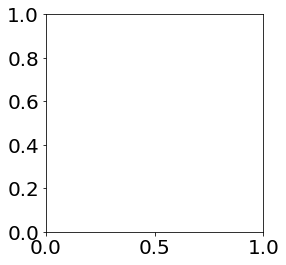

In [22]:
def panel_glodap_pO2(depth_index=3):
    data_O2 = glodap_dsO2['oxygen'].sel(depth_surface = depth_index)
    ax = plt.imshow(data_O2)
    # ... , figsize=(16, 10),cmap=cmocean.cm.oxy,vmin=150, vmax=350)
    # if depth_index == 0: msg = 'surface water'
    # else:                msg = 'water at depth ' + str(int(glodap_dsO2['Depth'].values[depth_index])) + ' meters'
    # plt.text(25, -87, msg)
    # plt.text(28, 50, 'oxygen dissolved in')
    # plt.text(28, 42, '     ocean water   ')
    return ax

app = pn.interact(panel_glodap_pO2, depth_index=(0, 32, 1))       # range and interval
# print(app)
fred = pn.Column("#### depth index chooser", pn.Row(app[0], app[1]))
# print(fred)
fred.show()

# Data Loader

Requires **`boto`** installed and target (local) data directory **`/data/glodap`** exist with write permission.

In [17]:
#######################################################################################
#
# Data loader for Glodap data
# 
# This code block is commented out. It gets the three data files from object storage on
#   the AWS public cloud. The data may at some point be discontinued at that location
#   but it is openly available through the GLODAP website.
#
# 
# Citation: Lauvset, S. K., Key, R. M., Olsen, A., van Heuven, S., 
#   Velo, A., Lin, X., Schirnick, C., Kozyr, A., Tanhua, T., Hoppema, 
#   M., Jutterström, S., Steinfeldt, R., Jeansson, E., Ishii, M., 
#   Perez, F. F., Suzuki, T., and Watelet, S.: 
#   A new global interior ocean mapped climatology: the 1° ×  1° GLODAP 
#   version 2, Earth Syst. Sci. Data, 8, 325–340, 
#   https://doi.org/10.5194/essd-8-325-2016, 2016.
# 
#   from https://www.earth-syst-sci-data.net/8/325/2016/
#
# Open issue: Does this 2016 dataset supersede the World Ocean Atlas as described at
#   https://climatedataguide.ucar.edu/climate-data/world-ocean-atlas-2013-woa13?
#
#
# If necessary: Install the boto library
# !conda install boto -y
#
# This code copies data files from AWS Object Storage (S3) to the local directory



if False:         # disabled once the datasets are loaded into /data/glodap

    
    
    glodapTemperatureFnm = data_dir + '/glodap/glodap_temperature.nc'
    glodapSalinityFnm    = data_dir + '/glodap/glodap_salinity.nc'
    glodapOxygenFnm      = data_dir + '/glodap/glodap_oxygen.nc'

    import boto
    from boto.s3.key import Key

    connection = boto.connect_s3(anon=True)
    bucket = connection.get_bucket('himatdata')

    for key in bucket.list(): 
        filename = key.name.encode('utf-8')
        if b'glodap' in filename: 
            if b'salinity.nc' in filename: 
                print ('salinity file is', filename)
                salinityfilename = filename
            if b'temperature.nc' in filename: 
                print ('temperature file is', filename)
                temperaturefilename = filename
            if b'oxygen.nc' in filename: 
                print('oxygen file is', filename)
                oxygenfilename = filename            

    k = Key(bucket)
    k.key = salinityfilename
    k.get_contents_to_filename(glodapSalinityFnm)
    k.key = temperaturefilename
    k.get_contents_to_filename(glodapTemperatureFnm)
    k.key = oxygenfilename
    k.get_contents_to_filename(glodapOxygenFnm)

    print('\ndata load complete for glodap')

## Data exploration

Here is some code to explore the data structure we used above; in a more technical 'how does this work?' sort of way.

In [ ]:
print(glodap_dsO2.Description)
print('\n')
print(glodap_dsO2.Citation)
dir(glodap_dsO2.oxygen.units)
print("\n" + glodap_dsO2.oxygen.units)

In [14]:
import inspect
print(inspect.getdoc(glodap_dsO2))

A multi-dimensional, in memory, array database.

A dataset resembles an in-memory representation of a NetCDF file,
and consists of variables, coordinates and attributes which
together form a self describing dataset.

Dataset implements the mapping interface with keys given by variable
names and values given by DataArray objects for each variable name.

One dimensional variables with name equal to their dimension are
index coordinates used for label based indexing.

To load data from a file or file-like object, use the `open_dataset`
function.

Parameters
----------
data_vars : dict-like, optional
    A mapping from variable names to :py:class:`~xarray.DataArray`
    objects, :py:class:`~xarray.Variable` objects or to tuples of
    the form ``(dims, data[, attrs])`` which can be used as
    arguments to create a new ``Variable``. Each dimension must
    have the same length in all variables in which it appears.

    The following notations are accepted:

    - mapping {var name: DataArr

In [15]:
glodap_dsO2['oxygen'][0:2,90:92,120:122].values

array([[[197.85690308, 196.35029602],
        [197.01686096, 195.4756012 ]],

       [[197.91693115, 196.32531738],
        [197.07067871, 195.68740845]]])

In [16]:
print(glodap_dsTemp['temperature'][0,20:24,160:200].values.mean())   
print(glodap_dsTemp['temperature'][0,80:100,160:200].values.mean())

-0.531661301580607
28.092354032993317
